# Differential Phosphosite Occupancy Analysis (DPOA) Results Processing

This notebook guides you through processing the results of Differential Phosphosite Occupancy Analysis (DPOA) on LC/MS-MS phosphoproteomics experiment data. The workflow includes estimating missing fold changes for phosphosites with insufficient quantification in control or condition samples. The methodology involves imputing these missing values based on the signal intensity distribution for each phosphosite across all samples, using Z-tests to estimate the distance from the distribution mean, and converting Z-scores into fold change values.

## Workflow Overview:
1. **Estimating Missing Fold Changes:** Impute missing fold changes using signal intensity distributions.

Let's start by importing necessary libraries and loading our dataset.

In [1]:
# Import necessary libraries
import pandas as pd
import os
import logging

# Import functions from the stats_functions module
import src.dpoa_processing as dpop
import src.visualisation as viz

# Configure logging
logging.basicConfig(level=logging.INFO)

# Set working directory
os.chdir('../')

## Loading Phosphoproteomics Data

We start by loading our dataset containing log2-transformed Area Under the Peak (AUP) data from LC-MS/MS phosphoproteomics experiments. Rows represent phosphosites (or features), and columns represent samples. We also load the results from the Differential Phosphosite Occupancy Analysis (DPOA).

In [2]:
# Load the dataset
log2aup = pd.read_csv('workspace/normalised_data.tsv', sep='\t', index_col=0)

# Display the first few rows of the dataset
log2aup.head()

,b1790p087_MCF7_AC220_1,b1790p087_MCF7_AC220_2,b1790p087_MCF7_AC220_3,b1790p087_MCF7_AC220_4,b1790p086_MCF7_Amuvatinib_1,b1790p086_MCF7_Amuvatinib_2,b1790p086_MCF7_Amuvatinib_3,b1790p086_MCF7_Amuvatinib_4,b1790p091_MCF7_AT13148_1,b1790p091_MCF7_AT13148_2,...,b1790p085_MCF7_U73122_3,b1790p085_MCF7_U73122_4,b1790p085_MCF7_Ulixertinib_1,b1790p085_MCF7_Ulixertinib_2,b1790p085_MCF7_Ulixertinib_3,b1790p085_MCF7_Ulixertinib_4,b1790p091_MCF7_Vemurafenib_1,b1790p091_MCF7_Vemurafenib_2,b1790p091_MCF7_Vemurafenib_3,b1790p091_MCF7_Vemurafenib_4
AAAS(S495),32.275187,32.045282,31.826052,31.750970,31.647925,31.617221,31.560099,31.644544,32.664284,32.406107,...,31.902911,31.712167,31.436421,31.742049,31.554497,31.991589,32.675892,32.429321,32.392129,32.320072
AAGAB(S310),28.180806,28.028627,28.647979,28.773045,28.201751,28.186011,27.190974,28.080992,25.712153,25.853753,...,NaN,NaN,28.958681,28.982276,25.678180,NaN,NaN,25.229066,NaN,25.968053
AAGAB(S311),28.982795,28.812147,29.207328,29.581376,28.201751,28.186011,27.190974,28.080992,26.356716,26.354416,...,NaN,NaN,28.958681,28.982276,25.678180,NaN,25.774717,26.466038,NaN,26.569418
AAK1(S14),28.953862,29.372768,26.986638,26.859847,27.409040,27.871342,27.673622,27.778439,30.928410,30.479325,...,30.134036,30.073872,29.931901,28.407864,29.864497,30.308223,30.417100,30.547670,30.105294,30.450151
AAK1(S21),29.602186,29.244308,29.541589,29.184223,28.458118,29.266445,29.137022,28.929294,28.923127,28.861004,...,29.088776,29.540386,29.178822,28.173655,28.898856,29.140419,28.558879,28.837722,28.938319,28.850593


In [3]:
# Load the dpoa results
dpoa = pd.read_csv('workspace/phosphodata_dpoa.tsv', sep='\t')

# Display the first few rows of the dpoa results
dpoa.head()

,phosphosite,perturbagen,fold_change,pval_eb,error,n_runs,p_mean,p_sd,n_ctr,meansig_ctr,n_cnd,meansig_cnd
0,AAAS(S495),AC220,0.154480,0.419533,NaN,276,32.003082,0.398753,32,32.009811,4,31.974373
1,AAGAB(S310),AC220,-0.531912,0.532569,NaN,231,27.575309,1.487023,27,27.794450,4,28.407614
2,AAGAB(S311),AC220,-0.456153,0.549161,NaN,248,27.896911,1.759238,31,27.825468,4,29.145912
3,AAK1(S14),AC220,-1.185440,0.039222,NaN,270,29.445774,1.139826,32,29.467779,4,28.043279
4,AAK1(S21),AC220,-0.045463,0.865075,NaN,270,29.062331,0.790405,32,29.391818,4,29.393077


# 1. Estimating Missing Fold Changes

In Differential Phosphosite Occupancy Analysis (DPOA), fold changes quantify the relative changes in phosphosite occupancy across different conditions. Missing FC values pose a challenge, occurring when phosphosites aren't quantified in control or treatment samples. This gap is significant because the absence of quantification — often due to low abundance — coupled with presence in another condition, suggests a notable change in phosphorylation, a crucial insight for our analysis.

The unavailability of quantified values hampers conventional analysis methods like Limma, which require numerical data to estimate differences. To overcome this, we employ a strategy that estimates missing fold changes using each phosphosite's signal intensity distribution across all samples. This methodology entails:

## Determining Signal Intensity Distribution

For each phosphosite, we calculate the mean and standard deviation of its signal intensities across all samples. This statistical insight forms the basis for our next steps in estimating missing fold changes.

AAAS(S495)     32.003082
AAGAB(S310)    27.575309
AAGAB(S311)    27.896911
AAK1(S14)      29.445774
AAK1(S21)      29.062331
dtype: float64
AAAS(S495)     0.398753
AAGAB(S310)    1.487023
AAGAB(S311)    1.759238
AAK1(S14)      1.139826
AAK1(S21)      0.790405
dtype: float64


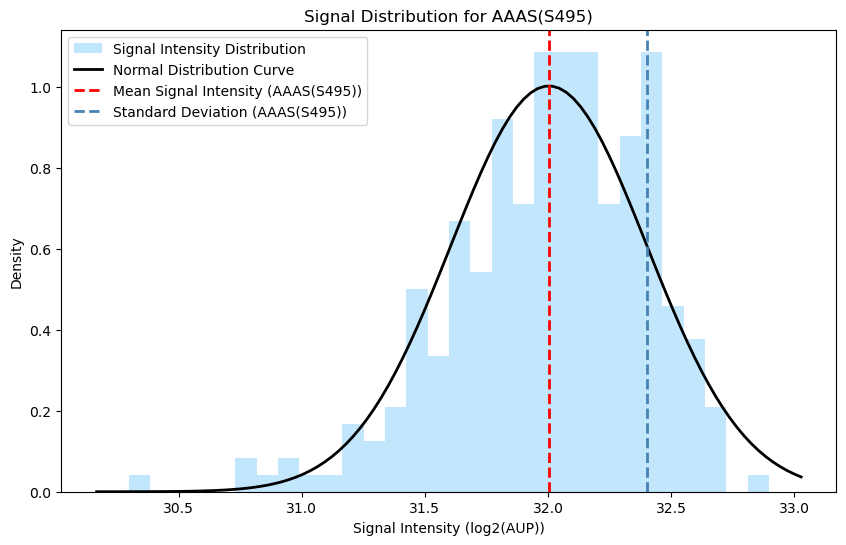

In [4]:
# Calculate mean and standard deviation for each phosphosite
signal_means = log2aup.mean(axis=1)
signal_stds = log2aup.std(axis=1)

# Example: Displaying the first five phosphosites
print(signal_means.head())
print(signal_stds.head())

# Plot the signal distribution for a given phosphosite across all samples
viz.plot_phosphosite_signal_dist(log2aup, log2aup.index[0])

## Z-score Estimation for Missing Data Imputation

We estimate the Z-score for a measurement's distance from its phosphosite's signal distribution, and convert Z-scores into fold change values. Depending on the available data, we distinguish between several cases:

### A. Cases where measurements are absent (mostly NA values) across control samples and all conditions
In scenarios where a phosphosite is unquantifiable in control samples (with fewer than 4 measurements) and across all conditions (less than 2 measurements in each condition), it suggests minimal phosphorylation or challenges in detection. Such phosphosites are likely to be of lower relevance to our analysis. These cases are preemptively filtered out during the quality control and normalization step detailed in '03-mh-perform-qc-and-normalise.ipynb'.

### B. Cases where measurements are absent across control samples and a specific condition X 
In cases where a phosphosite could not be quantified in control samples (< 4 measurements) as well as in a specific condition X of interest (< 2 measurements), yet exhibits sufficient data in other conditions, we assume minimal phosphorylation levels both in the control and condition X. Under these circumstances, we infer the phosphorylation event as potentially insignificant for the condition X when compared to control, assigning a fold change (FC) of 0.

In [5]:
# Define the condition for which FC should be updated
maskB = (dpoa['error'] == 'control_missing') & (dpoa['n_cnd'] < 2)

# Update FC based on the condition
dpoa_cB = dpoa.copy()
dpoa_cB.loc[maskB, 'fold_change'] = 0

# Display the updated sections of the dataset
dpoa_cB[maskB].head()

,phosphosite,perturbagen,fold_change,pval_eb,error,n_runs,p_mean,p_sd,n_ctr,meansig_ctr,n_cnd,meansig_cnd
810019,ABLIM1(S216),AC220,0.0,NaN,control_missing,11,23.813643,1.119241,1,23.793417,0,NaN
810020,ADD2(S532),AC220,0.0,NaN,control_missing,51,25.850168,1.803849,3,25.018199,1,32.480753
810021,ADGRL2(S1275),AC220,0.0,NaN,control_missing,18,24.451502,1.176154,1,25.191372,0,NaN
810022,AGPS(S65),AC220,0.0,NaN,control_missing,17,30.835485,0.575210,3,30.590581,0,NaN
810023,AHNAK2(S332),AC220,0.0,NaN,control_missing,24,22.544017,1.772794,1,23.392039,0,NaN


### C. Cases where measurements are absent across control samples (but not the condition X)
For phosphosites quantified in a condition X (>= 2 measurements) but not in control samples (< 4 measurements), we assume an increased phosphosite occupancy in the condition compared to control. However, because control samples are absent, instead of comparing the mean signal of a condition X to the control, we compare it to the mean signal of that same phosphosite across all conditions instead. We estimate fold changes using a Z-test approach as follows:

- Considering an intensity close to the distribution mean (Z=0) as a fold change of 1.
- Interpreting a negative Z-score as a fold change between 0 and 1.
- Interpreting a positive Z-score as a fold change between 1 and 2 for missing controls.

In [6]:
dpoa_cC = dpop.estimate_missing_fcs(dpoa_cB, 'control_missing')
maskC = (dpoa_cC['error'] == 'control_missing') & (dpoa_cC['n_cnd'] >= 2)
dpoa_cC[maskC].head()

INFO:root:Updated 1441 fold changes where 'control_missing'.


,phosphosite,perturbagen,fold_change,pval_eb,error,n_runs,p_mean,p_sd,n_ctr,meansig_ctr,n_cnd,meansig_cnd
810028,ALPK3(S1855),AC220,0.581811,NaN,control_missing,22,23.911593,1.829947,2,24.322926,4,24.652325
810046,ATXN2(S533),AC220,0.799376,NaN,control_missing,12,24.463455,3.210877,1,17.616076,2,27.369099
810052,BIN2(S462),AC220,-0.893996,NaN,control_missing,38,25.319601,1.812602,2,26.592219,2,23.247832
810059,CAMSAP1(S1398),AC220,0.657320,NaN,control_missing,52,26.775384,0.760581,1,26.150254,2,27.285705
810066,CEP170(S1079),AC220,0.441612,NaN,control_missing,59,22.560223,1.712308,0,NaN,3,23.138790


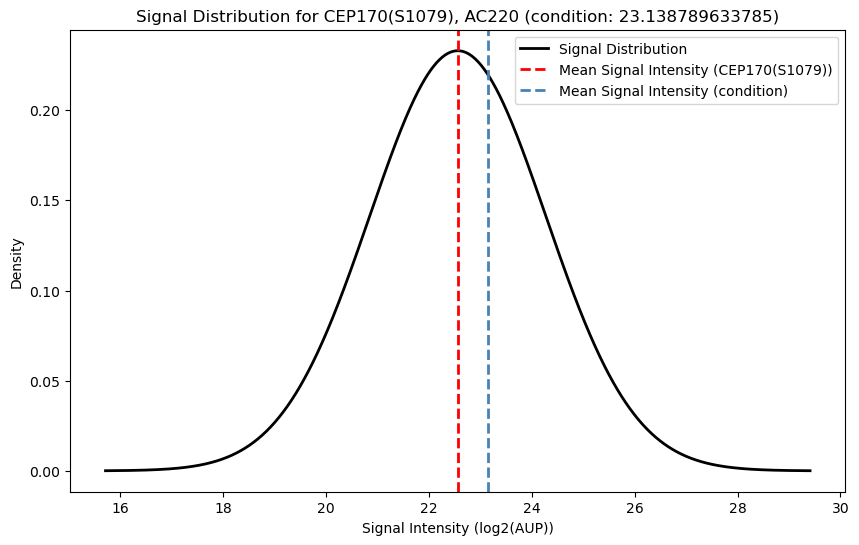

In [7]:
# Plot the signal distribution for a specific phosphosite and its signal intensity for a given condition to visualise its distance from mean
viz.plot_distance_to_signal_dist(dpoa_cC, phosphosite='CEP170(S1079)', perturbagen='AC220', na_error='control_missing')

### D. Cases where measurements are absent within a specific condition X (but not control samples)

In cases where a phosphosite is adequately quantified in control samples (>= 4 measurements) but lacks quantification in a particular condition X (< 1 measurement), we interpret this as an increased phosphosite occupancy within condition X relative to the control. Rather than directly comparing the mean signal of condition X to the control, we evaluate the mean signal of the phosphosite across all conditions against the control. To estimate fold changes under these circumstances, we employ a Z-test, adjusting the results to reflect decreased phosphosite occupancy by multiplying fold changes by -1:

- Considering an intensity close to the distribution mean (Z=0) as a fold change of -1.
- Interpreting a negative Z-score as a fold change between 0 and -1.
- Interpreting a positive Z-score as a fold change between -1 and -2 for missing controls.

In [8]:
dpoa_cD = dpop.estimate_missing_fcs(dpoa_cC, 'condition_missing')
maskD = (dpoa_cD['error'] == 'condition_missing') & (dpoa_cD['n_cnd'] == 0)
dpoa_cD[maskD].head()

INFO:root:Updated 50109 fold changes where 'condition_missing'.


,phosphosite,perturbagen,fold_change,pval_eb,error,n_runs,p_mean,p_sd,n_ctr,meansig_ctr,n_cnd,meansig_cnd
40,ABI2(Y213),AC220,0.393839,NaN,condition_missing,67,26.217393,2.919643,12,25.782864,0,NaN
53,ABLIM1(T433),AC220,-0.601859,NaN,condition_missing,155,27.275005,1.218208,15,27.540774,0,NaN
70,ACIN1(S132),AC220,-0.602568,NaN,condition_missing,120,27.421299,2.025300,15,27.863812,0,NaN
86,ACIN1(S863),AC220,-0.981216,NaN,condition_missing,178,27.938498,1.440378,28,28.578124,0,NaN
100,ACTB(Y294),AC220,-0.031979,NaN,condition_missing,67,25.253259,1.520618,8,25.274812,0,NaN


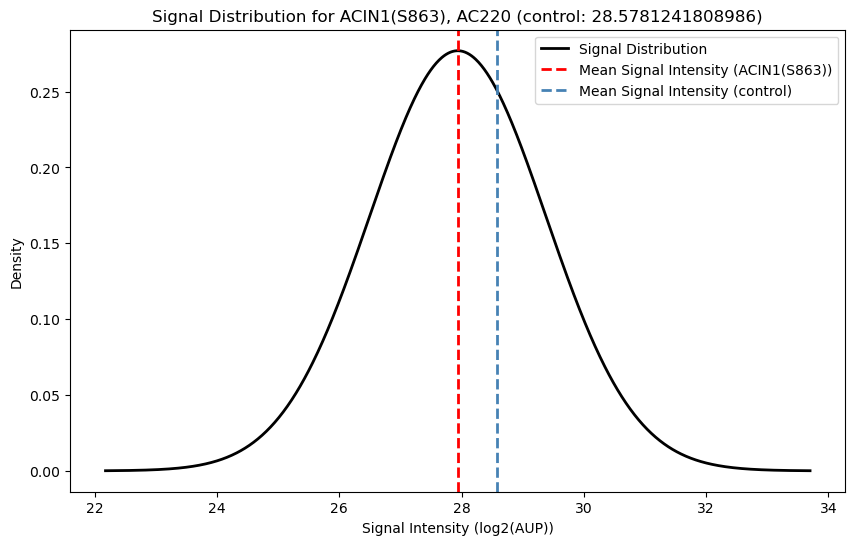

In [9]:
# Plot the signal distribution for a specific phosphosite and its signal intensity in the control
viz.plot_distance_to_signal_dist(dpoa_cD, phosphosite='ACIN1(S863)', perturbagen='AC220', na_error='condition_missing')

# Conclusion

This workflow enhances the completeness and accuracy of DPOA results by addressing missing fold changes. By imputing these values, we ensure that our dataset is more robust and reflective of the true biological variation observed in phosphoproteomics experiments.